<a href="https://colab.research.google.com/github/franzis17/EnronEmailAnalysis/blob/main/Development_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Program Initialisation

## Source of data

Upload the database containing the dataset to be analysed.<br>
<b>Note:</b> Only run if the database is stored in Google Drive

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Packages
Initialise all packages needed in the program. Packages used:
* calendar --> for showing the month name instead of the number of the month
* matplotlib --> for visualisation purposes. Plot the data in to some kind of a chart.
* pandas --> for efficiently sorting different kinds of data (i.e. sorting messages data in a monthly order)
* sqlite3 --> for extracting data in the database and perform 3 different kinds of analysis on the data

In [ ]:
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import re  # regular expression
import sqlite3
from wordcloud import WordCloud

# Generate Stopwords - Obtained from Ref[2]
from google.colab import output
!curl -Ol https://raw.githubusercontent.com/michael-borck/isys2001-worksheets/main/stopwords.py
output.clear()
print("Required packages installed")

## Connect to the database

<b>Note:</b> Must change the path of the database as needed.


In [ ]:
path_to_db = '/content/drive/MyDrive/a-quick_uploads/enron.db'

# Connect to the database using 'sqlite3'
conn = sqlite3.connect(path_to_db)

# Create a cursor to navigate each rows in the database and query any specific data from the dataset
cur = conn.cursor()

# Functions

* MUST run the following functions before any analysis.
* The functions below acts as modules used by multiple analysis methods to decrease code repetition.

In [ ]:
def query_db(table_name):
    sql='''
    SELECT * FROM {}
    '''.format(table_name)
    return pd.read_sql(sql, conn)

def query_db_for_messages():
    return query_db('message')

def query_db_for_employees():
    return query_db('employeelist')

def query_db_for_recipients():
    return query_db('recipientinfo')

# <u>**Analysis 1.**</u> Email Traffic Over Time

Aim: Analyze the volume of emails sent over time by counting the number of messages of each employees sent per month.

## **Problem:**
* Must count the total number of messages of all employees they are sending per month.

## **Inputs:**
* List of messages

## **Outputs:**
* A line chart that shows the number of emails per month. (x = month, y = number of emails(messages))

## **Algorithm:**
  1. Create a dataframe based on an SQL statement that obtains all messages from the database table "message".
  2. Using the "message" dataframe, use the total amount of messages of the dataframe to sort the data yearly.
  3. Using the yearly-sorted messages data, create a line chart that shows the total amount of messages per year.

## **Python Implementation:**

### <b>Total number of messages per year</b>

In [ ]:
'''
Note:
> Lines 13 to 20 were generated by ChatGPT. More info on Ref.ChatGPT[1]
'''

messages_df = query_db_for_messages()

# Make a new year table to sort the total number of messages by year
messages_df['date'] = pd.to_datetime(messages_df['date'], errors='coerce')
messages_df['year'] = messages_df['date'].dt.year
messages_per_year = messages_df.groupby('year').size()

# Plot the total number of messages per year
plt.figure(figsize=(15,5))
messages_per_year.plot(kind='line', marker='o')
plt.xticks(messages_per_year.index, rotation=90)
plt.xlabel('Year')
plt.ylabel('Number of messages per year')
plt.title('Total Number of Messages Per Year')
plt.show()

## <b>Total number of messages per month in the year 2001</b>

### <b>Algorithm</b>
1. Get all messages from the database
2. Filter it to only be the year '2001'
3. Calculate the total number of messages per month
4. Group the months chronologically (Jan to Dec)
5. Plot the data to a line chart

In [ ]:
'''
Note:
  > Lines 8 to 29 were generated by ChatGPT. More info on Ref.ChatGPT[3]
'''

messages_df = query_db_for_messages()

date_df = pd.DataFrame()
year_2001_df = pd.DataFrame()

messages_df['date'] = pd.to_datetime(messages_df['date'], errors='coerce')

year_2001_df = messages_df[(messages_df['date'].dt.year == 2001)]

messages_per_month = year_2001_df.groupby(year_2001_df['date'].dt.month).size()

# Get the month names corresponding to the month numbers
month_names = [calendar.month_name[month_num] for month_num in messages_per_month.index]

# Create a line chart showing the messages per month
messages_per_month.plot(kind='line', marker='o')
plt.title('Number of Messages in Each Month in 2001')
plt.xlabel('Month')
plt.ylabel('Number of Messages')

# Set the x-axis tick labels as the month names
plt.xticks(messages_per_month.index, month_names, rotation='vertical')

plt.show()

# **Analysis 2.** Top Senders and Receivers
Aim: Identify the most frequent email senders and recipients by aggregating(collecting) the data in the 'Message' and 'RecipientInfo' tables.

## **Problems:**
* Must find the most frequent email senders
* Must find the most frequent email receivers

## **Inputs:**
* Dataset of all senders from the "message" database table
* Dataset of all receivers from the "recipientinfo" database table

## **Outputs:**
* A set of all the most frequent email senders
* A set of all the most frequent email receivers

## **Algorithm:**

Finding the most frequent email <b><i>senders</i></b>:
1. Get all the messages from the database
2. Get all the employees from the database
3. Merge both 2 datasets, messages and employees, in order to count how much messages are sent by an employee.
4. Calculate the top senders who have the most number of messages sent
5. Sort from highest to lowest email sent
6. Using the sorted data set, plot it all on a bar chart with: x = total number of emails sent and y = employee name

Finding the most frequent email <b><i>receivers</i></b>:
1. Get all dataset of recipientinfo from 'recipientinfo' database table
2. Get all dataset of messages from 'messages' database table
3. Merge both 2 datasets, messages and recipientinfo, in order to <u>count</u> how much messages each employee has <b>received</b>
4. Calculate the top recipients who have the most received email.
5. Sort the recipients in order of highest to lowest number of emails received
6. Using the sorted data set, plot it all on a bar chart with: x = total number of emails received and y = employee name

## **Python Implementation:**

### <b>Top 20 Email <i>Senders</i></b>

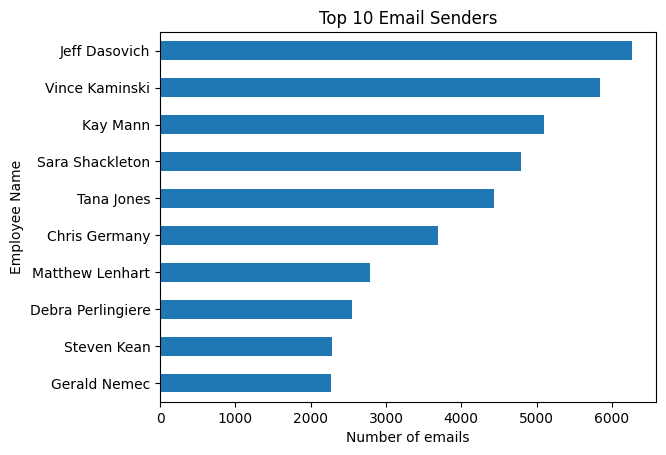

In [11]:
'''
Lines 9 to 24 are generated by ChatGPT: more info on Ref.ChatGPT[2]
'''

# Obtain all messages and employees from the database
messages_df = query_db_for_messages()
employees_df = query_db_for_employees()

# Merges the datasets 'messages' and 'employees' to count which messages are whose
merged_df = messages_df.merge(employees_df[['Email_id', 'firstName', 'lastName']], left_on='sender', right_on='Email_id', how='left')

# Get each employees full name by combining their firstName and lastName
merged_df['fullName'] = merged_df['firstName'] + ' ' + merged_df['lastName']

# Count the number of messages based on the amount of each unique email addresses
employee_counts = merged_df['fullName'].value_counts()
top_employees = employee_counts.head(10)

# Plot to Bar Chart the employees who have the highest email sent
top_employees.sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Number of emails')
plt.ylabel('Employee Name')
plt.title('Top 10 Email Senders')
plt.show()

### <b>Top 20 Email <i>Receivers</i></b>

In [ ]:
'''
Lines 9 to 24 are copied from "Top 10 Email Senders" and changed to merge
recipients and employees dataset instead of messages and employees
'''

# Obtain all recipients and employees from the database
recipients_df = query_db_for_recipients()
employees_df = query_db_for_employees()

# Merges the datasets 'messages' and 'recipientinfo' to count how many emails are received by each employees
merged_df = recipients_df.merge(employees_df[['Email_id', 'firstName', 'lastName']], left_on='rvalue', right_on='Email_id', how='left')

# Get each employees full name by combining their firstName and lastName
merged_df['fullName'] = merged_df['firstName'] + ' ' + merged_df['lastName']

# Count the number of messages based on the amount of each unique email addresses
employee_counts = merged_df['fullName'].value_counts()
top_employees = employee_counts.head(10)

# Plot to Bar Chart the employees who have the highest email sent
top_employees.sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Number of emails')
plt.ylabel('Employee Name')
plt.title('Top 10 Email Receivers')
plt.show()

# **Analysis 3.** Subject Keyword Analysis
Aim: Extract keywords from email subjects in the 'Message' table and analyze the frequency of words used to understand common topics of discussion.

## Problem:

* Must understand the common topics of discussion from the dataset of 'Message' table to see if it is related to any potential fraudulent activities.

## Inputs:

* List of words from the subject section of all email email messages. (database table located in message.subject)

## Outputs:

* WordCloud that shows the most common words used in the subject section of the email with. (Frequency of words depends on the size, i.e. large-sized words are most frequently used and smaller-sized are less frequent.)

# Algorithm:
  1. Extract all messages from the 'message' table.
  2. Clean the 'subject' contents of the message dataset to only contain absolute words (words must not contain any symbols/numbers)
  3. Generate list of "stop words" called "ENGLISH_STOP_WORDS" from Stopwords.py, which is a list of words that do not provide much meaning to the analysis.
  4. Create a WordCloud using the cleaned List of "subject" words.

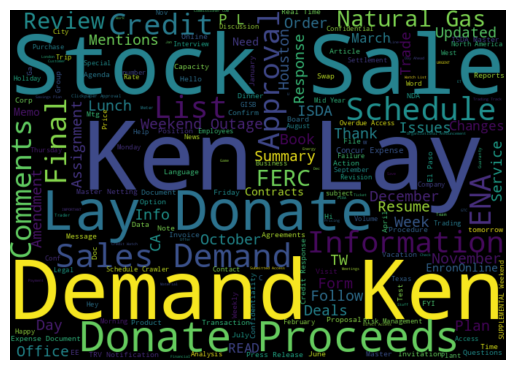

In [13]:
from stopwords import ENGLISH_STOP_WORDS

messages_df = query_db_for_messages()

# Obtained from Curtin Tutorial Ref[2]
def clean(text):
    ''' Uses regular expresison to extract english letter and digits from the supplied text. '''
    regExp = "(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"
    return ' '.join(re.sub(regExp, " ", text).split())

# Create a new column as a placeholder for the clean subject keywords
messages_df['Clean Subject'] = messages_df['subject'].apply(clean)

# Add additional words to stopwords that do not have much meaning
additional_stop_words = {'New', 'Meeting', 'Update', 'Enron', 'Market', 'Power',
    'Caiso', 'Notice', 'Hour', 'HourAhead', 'California', 'FW', 'Date', 'Fwd',
    'Letter', 'Deal', 'Draft', 'Report', 'Contract', 'Conference', 'Start',
    'Codesite', 'PG E', 'Agreement', 'Request', 'Issue', 'Change', 'PG', 'Revised',
    'Presentation', 'Today', 'Question', 'Status', 'EOL', 'Mention', 'Comment',
    'Employee', 'E', 'Confirmation', 'Project', 'Reminder'}
ENGLISH_STOP_WORDS.update(additional_stop_words)

# Create and Display the wordcloud
subjects = ' '.join(messages_df['Clean Subject'])
wordcloud = WordCloud(width=680, height=480, margin=0, stopwords=ENGLISH_STOP_WORDS).generate(subjects)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

# Miscellaneous Database Operations (Not a part of Analysis)
Purpose = to get details about the database


### View Database Schema
In other words ==> View the all database tables existing in the database

In [ ]:
sql='''
SELECT name FROM sqlite_master WHERE type='table';
'''
cur.execute(sql)
cur.fetchall()

### View contents of a database table

In [ ]:
# Get all messages
sql='''
SELECT * FROM message
'''
messages_df = pd.read_sql(sql, conn)

# Sort the date to monthly amount of messages in the year 2000
idx = pd.date_range(start='2000', end='2001', freq='M')
ts = pd.Series(range(len(idx)), index=idx)
messages_df
# must have a way to get the frequency of messages per month

## Close the connection to the database
**Note:** Use when done with the database

In [ ]:
conn.close()

# Reference List

* [1] https://pandas.pydata.org/docs/user_guide/10min.html#plotting
* [2] Obtained from WK-9 tutorial of Unit ISYS2001-IBP from Curtin University
* [3] Investopedia. https://www.investopedia.com/updates/enron-scandal-summary/#:~:text=However%2C%20the%20entire%20edifice%20was,the%20world%20at%20that%20time
* [4] Linkurious. About Jeff Dasovich. https://linkurious.com/blog/investigating-the-enron-email-dataset/
* [5] NYTimes. About Vince Kaminski. https://www.nytimes.com/2006/03/15/business/businessspecial3/exenron-officer-says-he-warned-of-shady.html
* [6] Brian. About Enron Executives. https://www.investopedia.com/enron-executives-6831970
* [7] James. About NYMEX. https://www.investopedia.com/terms/n/nymex.asp#:~:text=NYMEX%20is%20a%20commodities%20trading,%2C%20energy%2C%20and%20agricultural%20commodities.
* [8] Wikipedia. About Wikipedia. https://en.wikipedia.org/wiki/TXU_Energy#:~:text=In%201984%2C%20DP%26L%2C%20TESCO%2C,Australia%2C%20Europe%20and%20North%20America.

**ChatGPT**
* [1]
  * Purpose: To plot the frequency of messages per month to a line chart
  * Prompt: how can I use pandas package in python to plot the frequency of messages per month in a year, given the messages data are in a dataframe.
  * Note: A couple of tweaks were adjusted to the prompt, in order to get a correct response. Like for example the total number of messages must be sorted by year.
* [2]
  * Purpose: To find which employees have sent the most emails and plot that data to a bar chart.
  * Prompt: Hi ChatGPT, you are awesome! I am currently using Pandas package in Python and I want to know the top senders of email. I have a dataframe called 'messages_df' that contains the columns ['sender', 'subject']. The 'sender' column contains each employee's email address. I have another dataframe called 'employees_df' that contains the columns ['firstName', 'lastName', 'Email_id', 'Email2', 'Email3', 'EMail4']. There is in fact a typo in 'EMail4' where 'M' is capital but keep in mind that column is still spelt 'EMail4'. Now all of the email columns contain all employee's email address. Given information of messages_df and employees_df, I want to join them together to create a new dataframe based on messages_df's sender column to either any employees_df's 'Email_id'/'Email2'/'Email3'/'EMail4'.
* [3]
  * Purpose: To plot the total number of messages per month in the year 2001
  * Prompt: I am using pandas and matplotlib packages in Python. I have "messages_df" which is a dataframe that contains all messages. I want to plot the total number of messages per month in the year 2001.
  * Prompt Tweaks:
    * I want to show the name of the month instead of the number of the month and sort the months chronologically.